In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
pip install arch

In [20]:
import os

import scipy

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch.univariate import arch_model

from statsmodels.tsa.api import VAR

In [21]:
df_gts = []
for term in os.listdir("PPT/googletrends"):
  df_gts.append(pd.read_csv("PPT/googletrends/" + term, index_col=0))
df_gts = pd.concat(df_gts, axis=1)
df_gts.index = pd.to_datetime(df_gts.index)
df_gts_pct = df_gts.pct_change().iloc[1:,:].replace([np.nan], 0).replace([np.inf], 1).replace([-np.inf], -1)

data_unprocess_agg_df_berttopics_lda_pivot_normal = pd.read_csv("PPT/data_unprocess_agg_df_berttopics_lda_pivot_normal.csv")
data_unprocess_agg_df_berttopics_lda_pivot_normal["0"] = pd.to_datetime(data_unprocess_agg_df_berttopics_lda_pivot_normal["0"])
data_unprocess_agg_df_berttopics_lda_pivot_normal_week = data_unprocess_agg_df_berttopics_lda_pivot_normal.groupby(pd.Grouper(key="0", freq='W')).mean()

data_all_topics_label = pd.read_csv("PPT/data_all_topics_label.csv")
labels = set(data_all_topics_label["label"])

label_topic_dict = dict()
for label in labels:
  label_topic_dict[label] = list(data_all_topics_label.index[data_all_topics_label["label"] == label])

df_label = pd.DataFrame(0, index=data_unprocess_agg_df_berttopics_lda_pivot_normal_week.index, columns=label_topic_dict.keys())
for label, label_list  in label_topic_dict.items():
  df_label[label] = data_unprocess_agg_df_berttopics_lda_pivot_normal_week.iloc[:, label_topic_dict[label]].mean(axis=1)

df_label = df_label.rename({"教育": "education", "无关": "irrelevant", "政治":"politics", "艺术":"art", "宗教":"religion", "灾害": "disaster", "科技": "technology",
                            "自然": "nature", "医疗": "medical", "污染": "pollution", "社会": "society", "经济": "economy", "能源": "energy", "Geoengineering": "geoengineering"}, axis=1)
df_label = df_label[[i for i in df_label.columns if i != "irrelevant"]]
df_label_pct = df_label.pct_change().iloc[1:,:].replace([np.nan], 0).replace([np.inf], 1).replace([-np.inf], -1)

df_pearson_label_p = pd.DataFrame("", index=df_label_pct.columns, columns=df_gts_pct.columns)
for x, label in df_label_pct.T.iterrows():
  for y, gt in df_gts_pct.T.iterrows():
    r, p = scipy.stats.pearsonr(label, gt)
    if r >= 0:
      df_pearson_label_p.at[x, y] = "%.2f" % r + ''.join(['*' for t in [.05, .01, .001] if p<=t])
    else:
      df_pearson_label_p.at[x, y] = ""

df_pearson_label_p.columns = [i.lower() for i in df_pearson_label_p.columns]
df_pearson_label_p_result = df_pearson_label_p.reindex(["geoengineering"]+ sorted([i for i in df_pearson_label_p.columns if i != "geoengineering"]), axis=1)
df_pearson_label_p_result.index = [i.lower() for i in df_pearson_label_p_result.index]
df_pearson_label_p_result = df_pearson_label_p_result.reindex(["geoengineering"]+ sorted([i for i in df_pearson_label_p.index if i != "geoengineering"]), axis=0)
df_pearson_label_p_result = df_pearson_label_p_result.T

col_included = []
for col, series in df_pearson_label_p_result.items():
  if sum(series.str.contains("*", regex=False)) >= 1:
    col_included.append(col)

data_unprocess_agg_df_sentiment = pd.read_csv("PPT/data_unprocess_agg_df_sentiment_tuned.csv")
data_unprocess_agg_df_sentiment["0"] = pd.to_datetime(data_unprocess_agg_df_sentiment["0"])
data_unprocess_agg_df_sentiment = data_unprocess_agg_df_sentiment.groupby(pd.Grouper(key="0", freq='W'))["3"].mean()

df_label_included_sentiment = pd.concat([df_label[col_included], df_gts, data_unprocess_agg_df_sentiment], axis=1).rename({"3": "sentiment"}, axis=1)
df_label_included_sentiment["category"] = df_label_included_sentiment.apply(lambda x: df_label_included_sentiment.columns[np.argmax(x[:len(col_included)])], axis=1)
df_label_included_sentiment = df_label_included_sentiment.iloc[:, len(col_included):]
df_label_included_sentiment = df_label_included_sentiment.rename({"Marine cloud brightening": "marine cloud brightening", "solar engineering": "solar geoengineering"}, axis=1)

df_timeseries = pd.concat([df_label[["disaster", "energy", "nature", "politics", "religion"]], df_gts.mean(axis=1).rename("Geoengineering Index")], axis=1)
df_timeseries = (df_timeseries - df_timeseries.min()) / (df_timeseries.max() - df_timeseries.min())

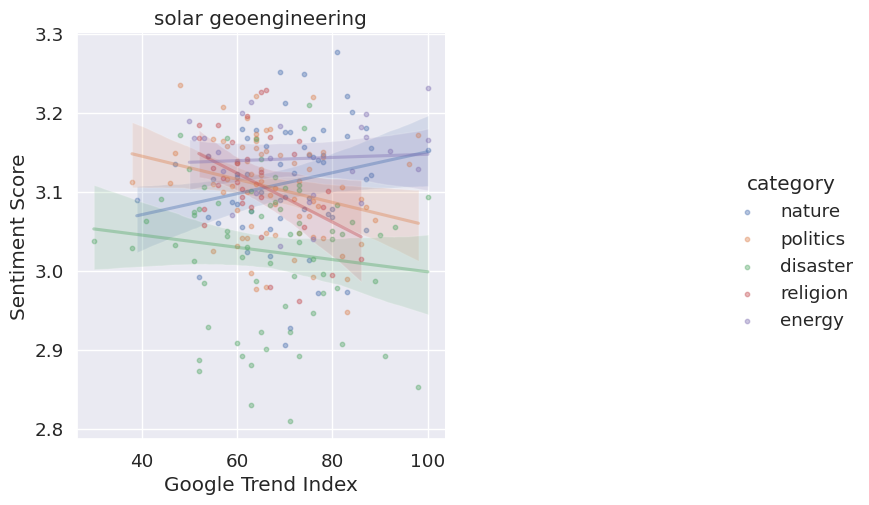

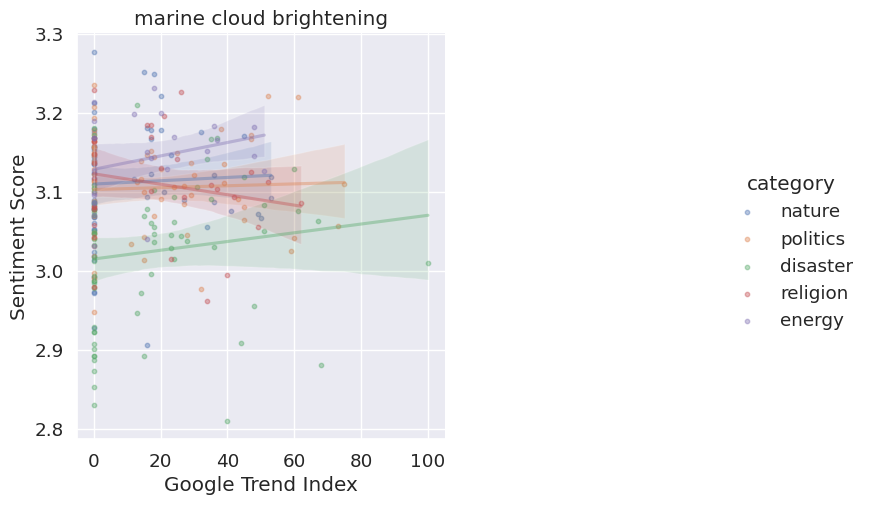

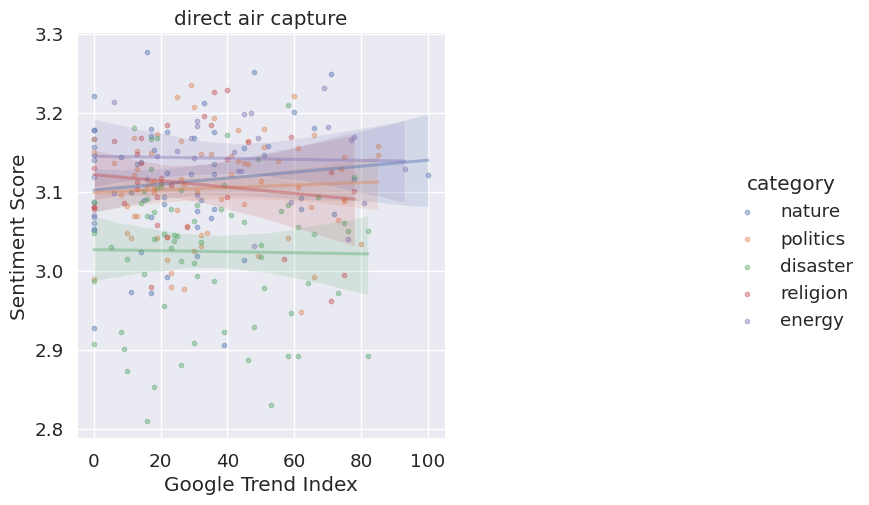

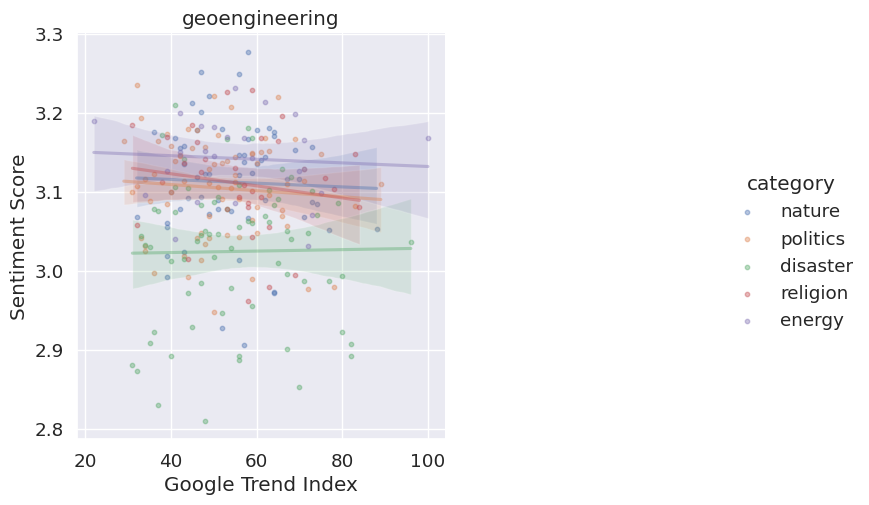

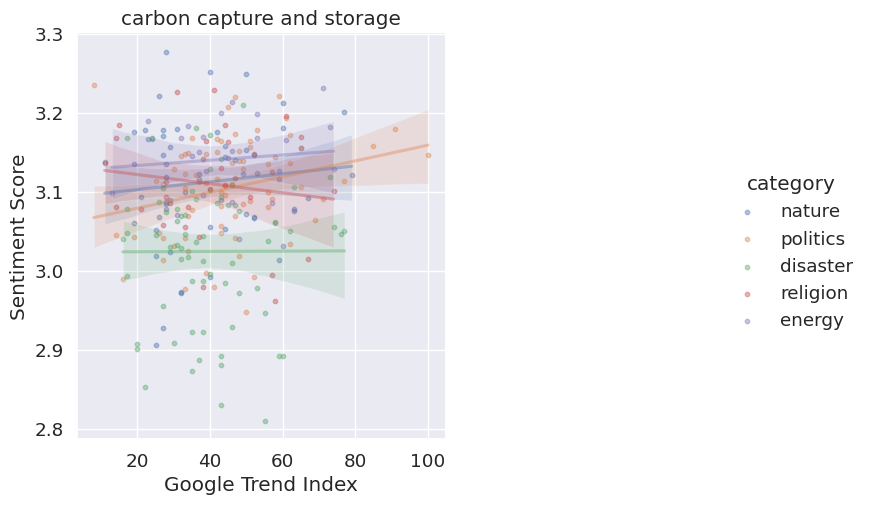

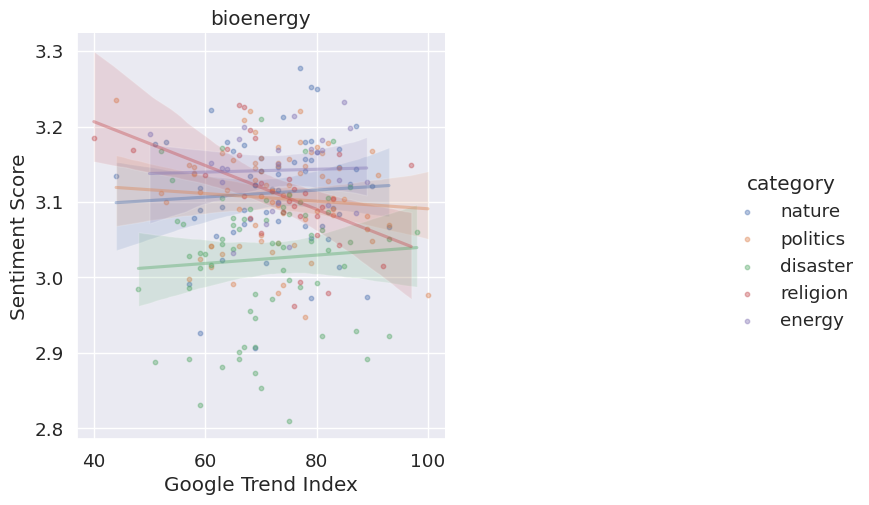

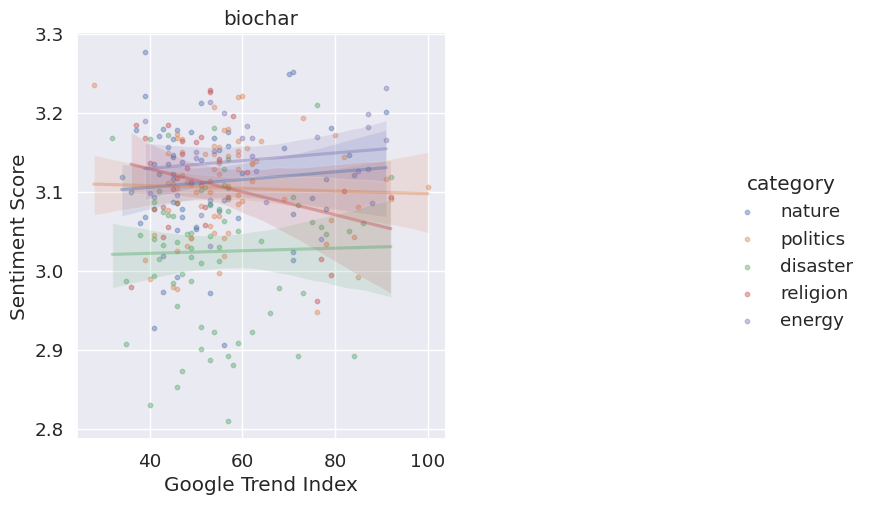

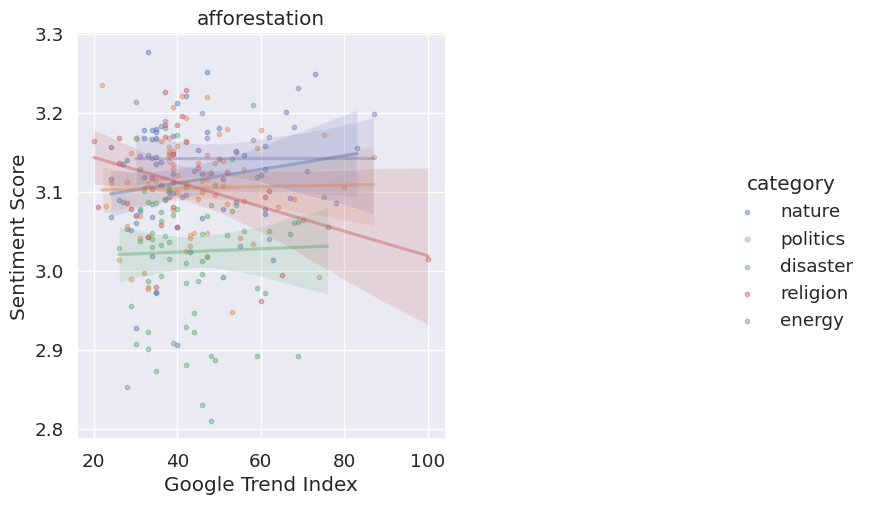

In [22]:
sns.set(font_scale = 1.2)
for x in ['solar geoengineering', 'marine cloud brightening', 'direct air capture', 'geoengineering', 'carbon capture and storage', 'bioenergy', 'biochar', 'afforestation']:
  g = sns.pairplot(df_label_included_sentiment, hue="category", kind="reg", x_vars=x,
                  y_vars=["sentiment"], plot_kws={'line_kws':{'alpha': 0.4}, 'scatter_kws': {'alpha': 0.4, 's': 10}})
  # g._legend.remove()
  g.fig.set_size_inches(10,6)
  # g.axes[0][0].set_ylim(1.8, 2.4)
  g.axes[0][0].set_title(x, y=1)
  g.axes[0][0].set_ylabel("Sentiment Score")
  g.axes[0][0].set_xlabel("Google Trend Index", y=1);

In [24]:
for c in df_label_included_sentiment.category.unique():
  print("\n\n" + c)
  for j in sorted([i for i in df_label_included_sentiment.columns if i not in  ["sentiment", "category"]]):
    df_temp = df_label_included_sentiment.loc[:, [j, "sentiment", "category"]]
    df_temp = df_temp[df_temp["category"] == c]
    stats = np.corrcoef(df_temp[j], df_temp["sentiment"])
    print(j + "%" + str(stats[0][1]))



nature
afforestation%0.15180978081516847
biochar%0.09003698307498552
bioenergy%0.06421917333501127
carbon capture and storage%0.10493900000352131
climate engineering%0.2620287346908512
direct air capture%0.11854066712821369
geoengineering%-0.03647844940263045
marine cloud brightening%0.04598415702695025
solar geoengineering%0.19888921724059433
stratospheric aerosol injection%-0.0740481172707039


politics
afforestation%0.022530229430195895
biochar%-0.03646636927745782
bioenergy%-0.08418700174962347
carbon capture and storage%0.26118721658418786
climate engineering%-0.04223713609435369
direct air capture%0.05548311283595768
geoengineering%-0.08118412584254438
marine cloud brightening%0.039035350212834316
solar geoengineering%-0.26074983765670906
stratospheric aerosol injection%-0.26079932276302253


disaster
afforestation%0.027788499321494683
biochar%0.02407229243940251
bioenergy%0.06593573526816061
carbon capture and storage%0.0031324460159303236
climate engineering%-0.13032370063284

In [25]:
data_unprocess_agg_df_berttopics = pd.read_csv("PPT/data_unprocess_agg_df_berttopics.csv")

data_all_topics_label = pd.read_csv("PPT/data_all_topics_label.csv")
label_name_dict = data_all_topics_label[["label", "Name"]].set_index("Name").to_dict()['label']
chinese_english_dcit = {"教育": "education", "无关": "irrelevant", "政治":"politics", "艺术":"art", "宗教":"religion", "灾害": "disaster", "科技": "technology",
                            "自然": "nature", "医疗": "medical", "污染": "pollution", "社会": "society", "经济": "economy", "能源": "energy", "Geoengineering": "geoengineering"}
data_unprocess_agg_df_berttopics["label"] = data_unprocess_agg_df_berttopics["3"].map(label_name_dict).map(chinese_english_dcit)
data_unprocess_agg_df_berttopics["sentiment"] = data_unprocess_agg_df_sentiment[3]

dfs = []
for label, df in data_unprocess_agg_df_berttopics.groupby(["label"]):
  label = label[0]
  df["0"] = pd.to_datetime(df["0"])
  df = df.rename({"sentiment": label}, axis=1).groupby(pd.Grouper(key="0", freq='D'))[label].mean()
  dfs.append(df)
df_sentiment_for_each_category = pd.concat(dfs, axis=1).fillna(0).reset_index().groupby(pd.Grouper(key="0", freq='W')).mean()
df_all_sentiment_for_each_category = pd.concat([df_gts.mean(axis=1).rename("Geoengineering Index"), df_sentiment_for_each_category], axis=1)
df_all_sentiment_for_each_category = (df_all_sentiment_for_each_category - df_all_sentiment_for_each_category.min()) / (df_all_sentiment_for_each_category.max() - df_all_sentiment_for_each_category.min())

<ipython-input-25-ed7ade558fb1>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_unprocess_agg_df_berttopics["sentiment"] = data_unprocess_agg_df_sentiment[3]


In [37]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(df_timeseries["Geoengineering Index"], autolag = 'AIC')
print("ADF : ",dftest[0])
print("P-Value : ", dftest[1])

ADF :  -2.6535037993506463
P-Value :  0.0824354590494979


In [27]:
mod_are = AutoReg(df_timeseries["Geoengineering Index"], 4, old_names=False, exog=df_timeseries[["disaster", "energy", "nature", "politics", "religion"]])
res_are = mod_are.fit()

mod_arimae = ARIMA(df_timeseries["Geoengineering Index"], order=(4,0,4), exog=df_timeseries[["disaster", "energy", "nature", "politics", "religion"]])
res_arimae = mod_arimae.fit()

mod_sarimaxe = SARIMAX(df_timeseries["Geoengineering Index"], order=(4, 0, 4), seasonal_order=(1, 0, 1, 52), exog=df_timeseries[["disaster", "energy", "nature", "politics", "religion"]])
res_sarimaxe = mod_sarimaxe.fit(maxiter=1000)

mod_garchxe = arch_model(df_timeseries["Geoengineering Index"], x=df_timeseries[["disaster", "energy", "nature", "politics", "religion"]], mean="ARX", lags=4)
res_garchxe = mod_garchxe.fit(disp="off")

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01212. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [28]:
mod_are_sentiment = AutoReg(df_all_sentiment_for_each_category["Geoengineering Index"], 4, old_names=False, exog=df_all_sentiment_for_each_category[["disaster", "energy", "nature", "politics", "religion"]])
res_are_sentiment = mod_are_sentiment.fit()

mod_arimae_sentiment = SARIMAX(df_all_sentiment_for_each_category["Geoengineering Index"], order=(4,0,4), seasonal_order=(0, 0, 0, 0), exog=df_all_sentiment_for_each_category[["disaster", "energy", "nature", "politics", "religion"]])
res_arimae_sentiment = mod_arimae_sentiment.fit(maxiter=1000)

mod_sarimaxe_sentiment = SARIMAX(df_all_sentiment_for_each_category["Geoengineering Index"], order=(4, 0, 4), seasonal_order=(1, 0, 1, 52), exog=df_all_sentiment_for_each_category[["disaster", "energy", "nature", "politics", "religion"]])
res_sarimaxe_sentiment = mod_sarimaxe_sentiment.fit(maxiter=1000)

mod_garchxe_sentiment = arch_model(df_all_sentiment_for_each_category["Geoengineering Index"], x=df_all_sentiment_for_each_category[["disaster", "energy", "nature", "politics", "religion"]], mean="ARX", lags=4)
res_garchxe_sentiment = mod_garchxe_sentiment.fit(disp="off")

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01231. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<ipython-input-70-09757ca7428d>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot([row[0], row[1]], [index-flag*0.2, index-flag*0.2], color=colors[flag][0])
<ipython-input-70-09757ca7428d>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot((row[0] + row[1]) / 2, index-flag*0.2, 'o', color=colors[flag][1])
<ipython-input-70-09757ca7428d>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot([row[0], row[1]], [index-

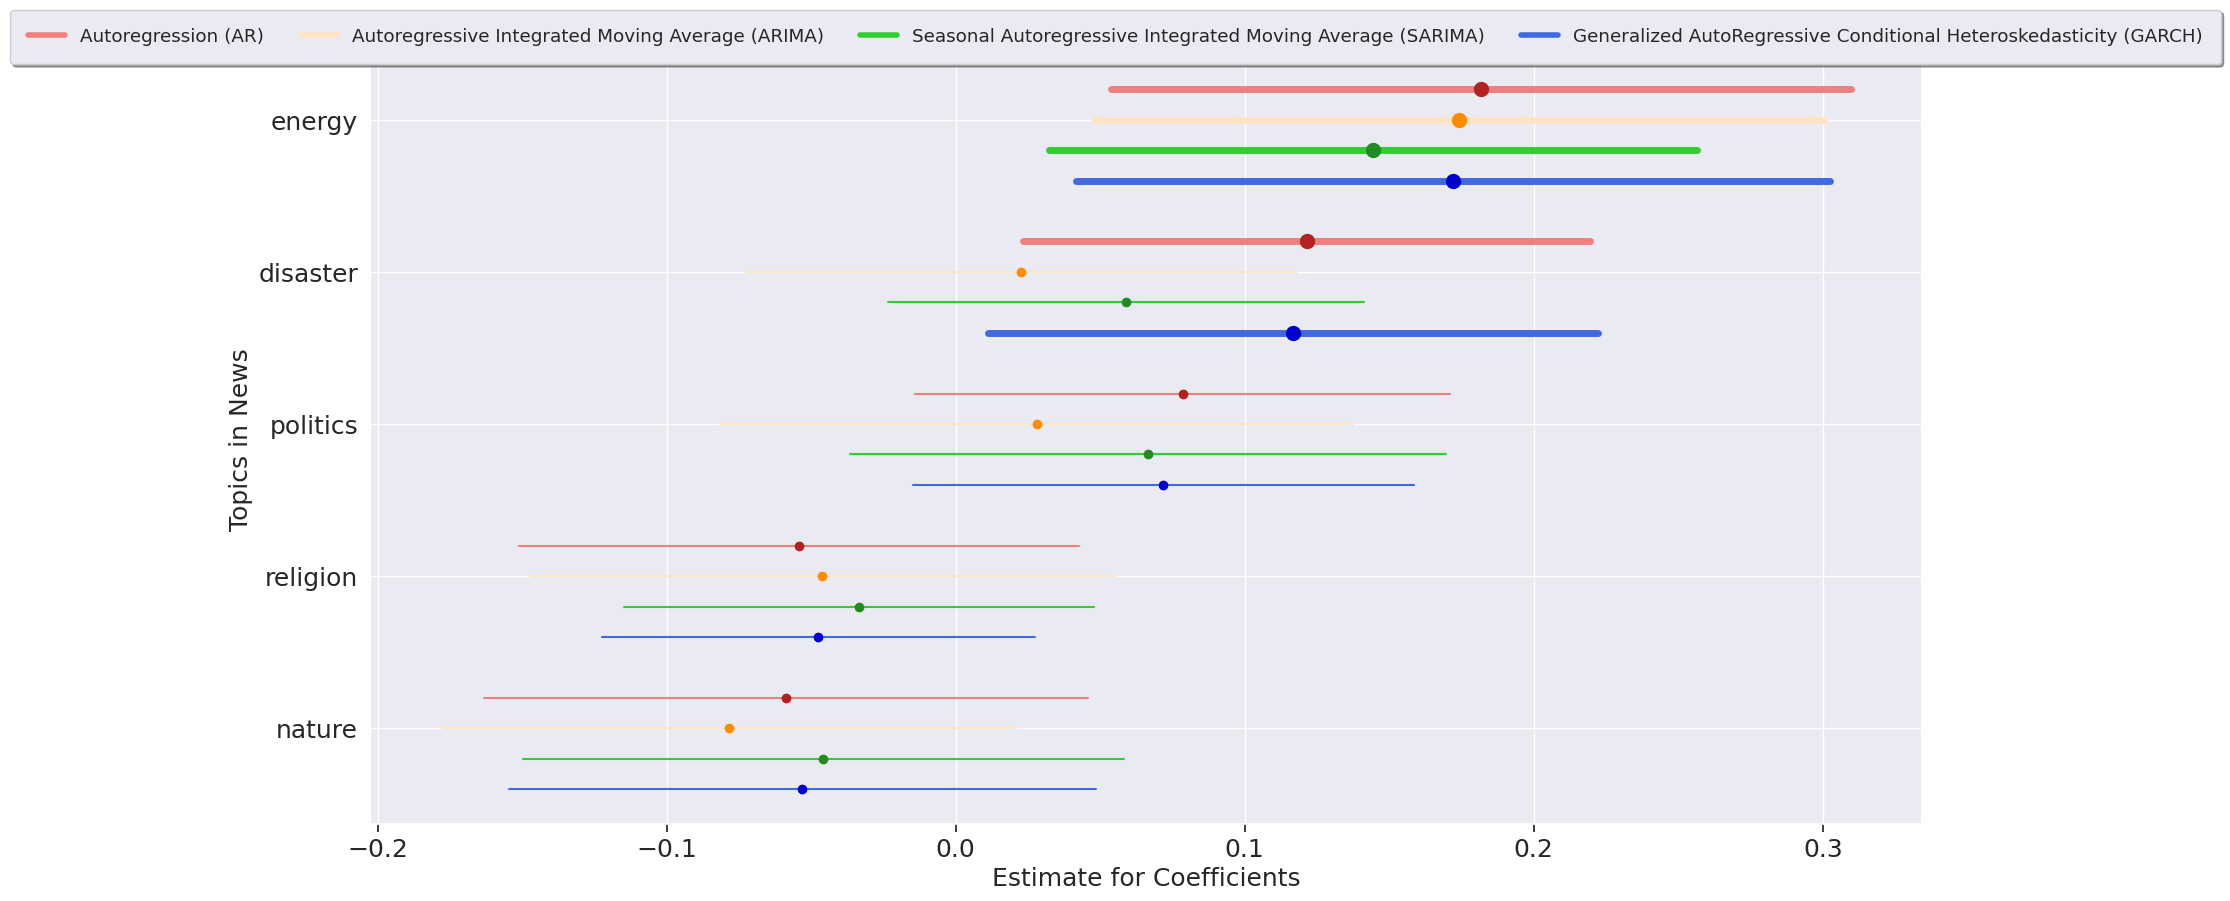

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
colors = {0: ["lightcoral", "firebrick"], 1: ["bisque", "darkorange"], 2: ["limegreen", "forestgreen"], 3: ["royalblue", "mediumblue"]}

for flag, res_e in enumerate([res_are, res_arimae, res_sarimaxe, res_garchxe]):
  df_conf = res_e.conf_int()
  df_conf = df_conf.loc[sorted(df_timeseries.columns[:-1])].sort_values(df_conf.columns[0])
  for index, (flagg, row) in enumerate(df_conf.iterrows()):
    if res_e.pvalues[flagg] <= 0.05:
      ax.plot([row[0], row[1]], [index-flag*0.2, index-flag*0.2], color=colors[flag][0], linewidth=5)
      ax.plot((row[0] + row[1]) / 2, index-flag*0.2, 'o', color=colors[flag][1], markersize=10)
    else:
      ax.plot([row[0], row[1]], [index-flag*0.2, index-flag*0.2], color=colors[flag][0])
      ax.plot((row[0] + row[1]) / 2, index-flag*0.2, 'o', color=colors[flag][1])

ax.set_yticks([0-0.2, 1-0.2, 2-0.2, 3-0.2, 4-0.2])
ax.set_yticklabels(df_conf.index)

ax.tick_params(axis='y', which='major', labelsize=18)
ax.tick_params(axis='x', which='major', labelsize=18)
ax.tick_params(top=False, bottom=True, left=False, right=False, labelleft=True, labelbottom=True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xlabel("Estimate for Coefficients", fontsize=18)
ax.set_ylabel("Topics in News", fontsize=18)

custom_lines = [Line2D([0], [0], color="lightcoral", lw=4),
                Line2D([0], [0], color="bisque", lw=4),
                Line2D([0], [0], color="limegreen", lw=4),
                Line2D([0], [0], color="royalblue", lw=4)]

ax.legend(custom_lines, ['Autoregression (AR)', 'Autoregressive Integrated Moving Average (ARIMA)',
                         'Seasonal Autoregressive Integrated Moving Average (SARIMA)',
                         'Generalized AutoRegressive Conditional Heteroskedasticity (GARCH)'], fancybox=True, framealpha=1, shadow=True, borderpad=1, loc='upper center', ncol=4, bbox_to_anchor=(0.48, 1.07));

<ipython-input-67-931a315331fd>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot([row[0], row[1]], [index-flag*0.2, index-flag*0.2], color=colors[flag][0])
<ipython-input-67-931a315331fd>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot((row[0] + row[1]) / 2, index-flag*0.2, 'o', color=colors[flag][1])
<ipython-input-67-931a315331fd>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot([row[0], row[1]], [index-

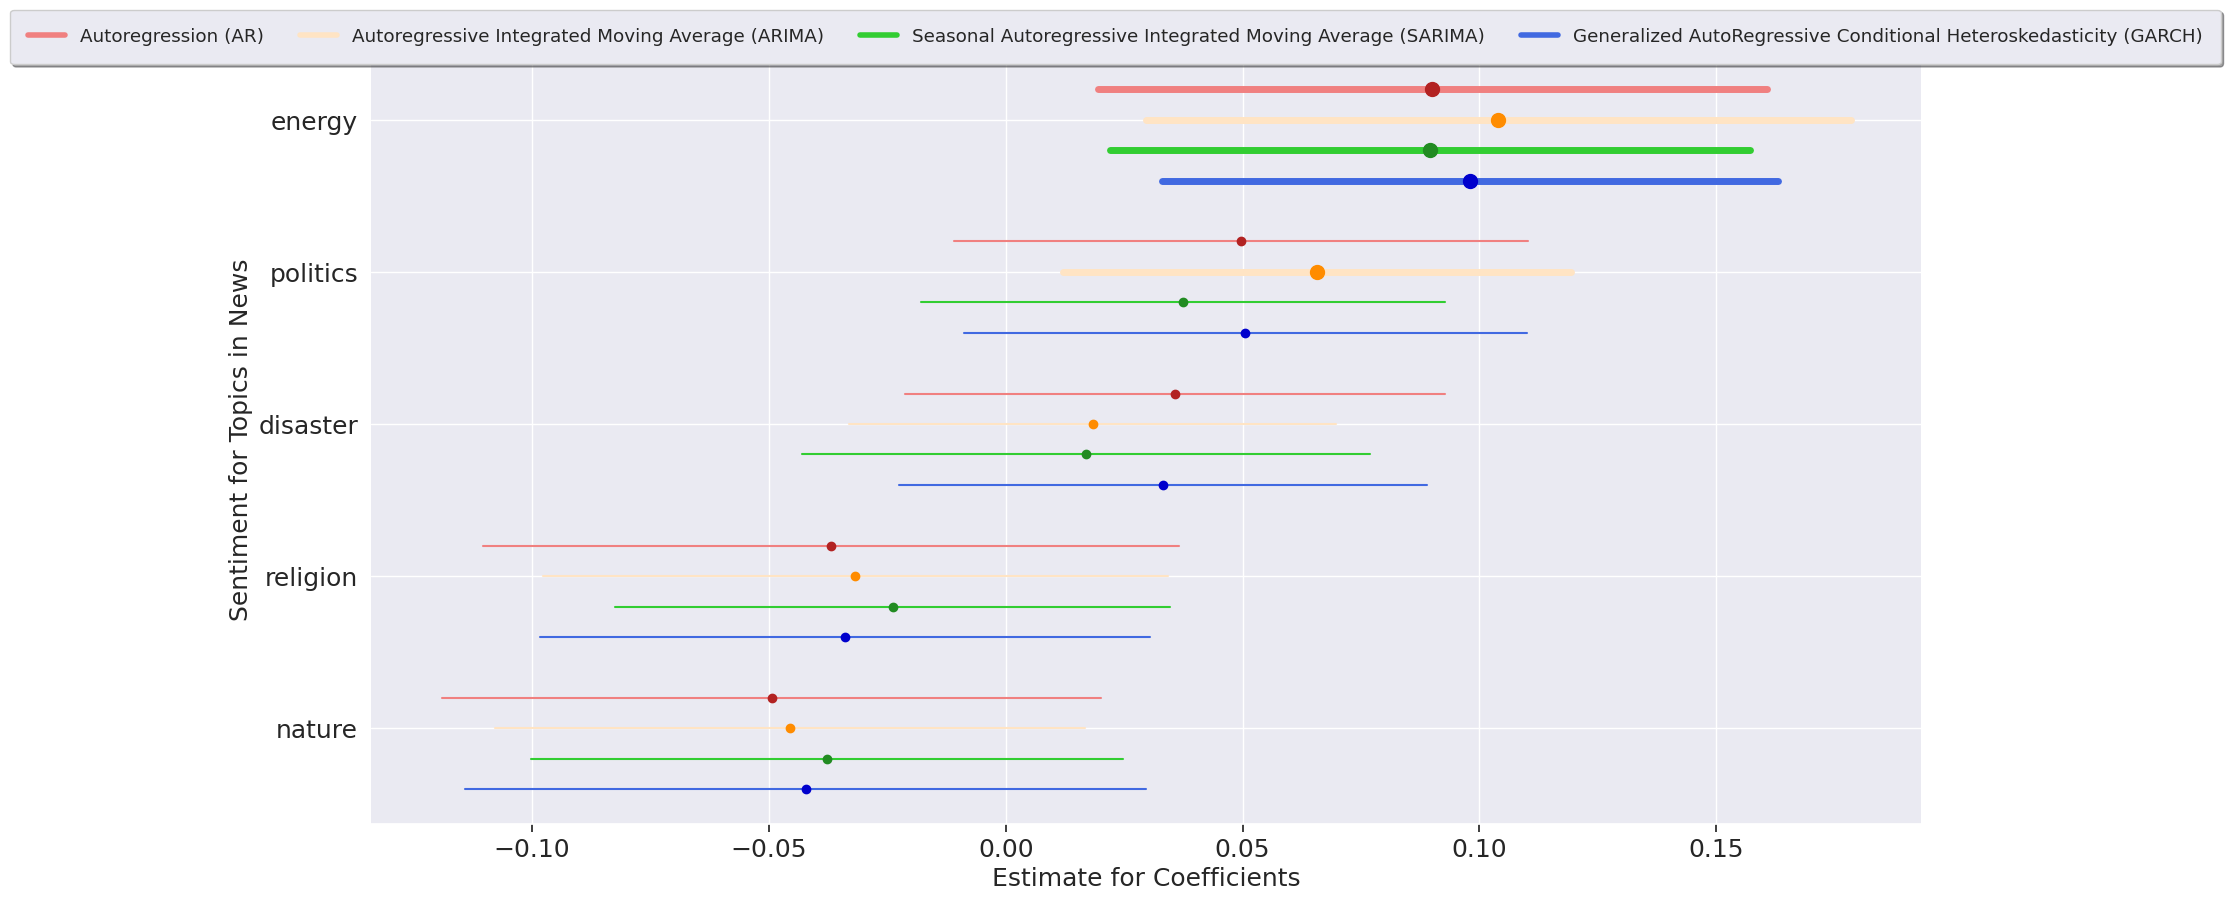

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
colors = {0: ["lightcoral", "firebrick"], 1: ["bisque", "darkorange"], 2: ["limegreen", "forestgreen"], 3: ["royalblue", "mediumblue"]}

for flag, res_e in enumerate([res_are_sentiment, res_arimae_sentiment, res_sarimaxe_sentiment, res_garchxe_sentiment]):
  df_conf = res_e.conf_int()
  df_conf = df_conf.loc[sorted(df_timeseries.columns[:-1])].sort_values(df_conf.columns[0])
  for index, (flagg, row) in enumerate(df_conf.iterrows()):
    if res_e.pvalues[flagg] <= 0.05:
      ax.plot([row[0], row[1]], [index-flag*0.2, index-flag*0.2], color=colors[flag][0], linewidth=5)
      ax.plot((row[0] + row[1]) / 2, index-flag*0.2, 'o', color=colors[flag][1], markersize=10)
    else:
      ax.plot([row[0], row[1]], [index-flag*0.2, index-flag*0.2], color=colors[flag][0])
      ax.plot((row[0] + row[1]) / 2, index-flag*0.2, 'o', color=colors[flag][1])

ax.set_yticks([0-0.2, 1-0.2, 2-0.2, 3-0.2, 4-0.2])
ax.set_yticklabels(df_conf.index)

ax.tick_params(axis='y', which='major', labelsize=18)
ax.tick_params(axis='x', which='major', labelsize=18)
ax.tick_params(top=False, bottom=True, left=False, right=False, labelleft=True, labelbottom=True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xlabel("Estimate for Coefficients", fontsize=18)
ax.set_ylabel("Sentiment for Topics in News", fontsize=18)

custom_lines = [Line2D([0], [0], color="lightcoral", lw=4),
                Line2D([0], [0], color="bisque", lw=4),
                Line2D([0], [0], color="limegreen", lw=4),
                Line2D([0], [0], color="royalblue", lw=4)]

ax.legend(custom_lines, ['Autoregression (AR)', 'Autoregressive Integrated Moving Average (ARIMA)',
                         'Seasonal Autoregressive Integrated Moving Average (SARIMA)',
                         'Generalized AutoRegressive Conditional Heteroskedasticity (GARCH)'], fancybox=True, framealpha=1, shadow=True, borderpad=1, loc='upper center', ncol=4, bbox_to_anchor=(0.48, 1.07));

In [ ]:
df_all_sentiment_for_each_category.to_csv("df_all_sentiment_for_each_category_tuned_2r.csv")